Приветствую того, кто читает этот код.В качестве научной работы в университете я занимаюсь спайковыми нейронными сетями. Основной библиотекой является brian2. Так как эта область довольно новая, каких-то готовых хороших алгоритмов для решения определенных задач практически нет, поэтому многое приходится делать методом проб и ошибок, а в этом очень сильно помогает визуализация данных и наш любимый matplotlib. 

В классических нейронных сетях простейшей задачей, с которой начинают новички является классификация mnist, но для спайковых сетей эта задача пока довольно сложная, поэтому в данной работе я покажу их работу на примере двухклассовой классификации датасета digits.

Кратко о спайковых нейронных сетях. Спайковый нейрон взят из биологии и представляет из себя элемент, который получает импульсы тока и накапливает потенциал на мембране. Когда потенциал превышает определенное значение нейрон передает импульс(спайк) к другим нейронам через связи, собственно веса связей между нейронами и подбираются в процессе обучения. В отличии от классических нейронных сетей, спайковые сети принимают на вход не одну картинку, а ряд из одной картинки, то есть они как бы смотрят на картинку втечение некоторого времени, заряжая мембраны нейронов. Так же между нейронами последнего слоя можно организовать конкуренцию за ток от входных нейронов, это позволяет ускорить обучение. Архитектура сети очень простая: входной слой по нейрону на каждый пиксель картинки и выходной слой 2 нейрона.

In [1]:
from brian2 import *
#import brian2cuda
#import brian2genn
#set_device('genn')
#set_device("cuda_standalone")
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
#Loading dataset Normalizing data to [0,1]
digits=datasets.load_digits(2)
data, y = (digits.images/16),digits.target

In [3]:
data.max()

1.0

<IPython.core.display.Javascript object>


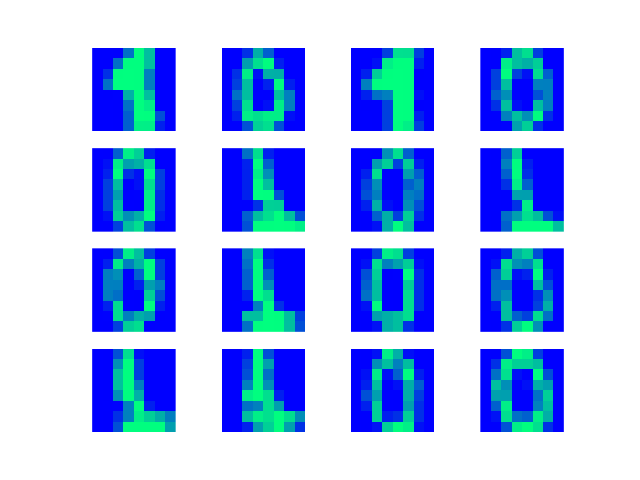

In [4]:
figure('data')
for j in np.arange(int(16)):
    subplot(4, 4, j+1)
    imshow(data[j+100].reshape(8, 8), cmap='winter', interpolation='None')
    axis('off')
    #print(y[j+100])
show()

data = data.reshape(-1, 64)

Задаем правила обучения сети и значения гиперпараметров. Спайковые сети описываются дифференциальными и алгебраическими уравнениями, определяющими взаимодействие нейронов и частоту спайкования, ещё тут довольно много гиперпараметров, которые нужно подбирать для нормального обучения.

In [5]:
start_scope()

n_input_width = 8.
n_input_height = n_input_width
n_input = n_input_width* n_input_height

n_hidden = 2

time_step = 0.1 * ms
alpha = 10 * ms
beta = 100 * ms
tau = 10*ms
tau_I = 15*ms
tau_h = 50*ms

wmax = 1.0
c_inp = 0.2
c_neg = 1.7  #8.8
lr = 0.05
lr_n = 0.01
decay = 0.001

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
train : 1
'''

eqs_hidden_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_neg/dt = -I_neg/tau_I :1
I_teacher : 1
I = I_inp + I_neg + I_teacher :1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - theta: 1
dhold/dt = -hold/tau_h : 1
train : 1
'''

reset_hidden = '''
v = 0
hold += 0.1 * n_hidden
'''

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./n_hidden *1*ms/(alpha)
theta_pre += 1./n_hidden *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
a_post += 1./n_input *1*ms/(alpha)
theta_post += 1./n_input *1*ms/(beta)
w = clip(w + train_pre * (-decay + lr*diff_pre), 0, wmax)
'''

eqs_neg_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-oriented synapse of input layer occures
eqs_neg_pre = '''
I_neg_post += w * c_neg
'''

#w = clip(w + train_pre*(+decay - lr_n * diff_post), -wmax, 0)

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_neg_post = '''
w = clip(w + train_pre*(-lr_n*diff_pre), -wmax, 0)
'''

Инициализируем значения параметров сети, нейронные группы и связи между нейронами.

In [6]:
P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', refractory=2*ms, dt = time_step, name='P')
P.rates = [k*250*Hz for k in data[0]]
P.train = np.ones_like(P.train)
P.a = np.random.rand(len(P))*0.5
P.theta = np.random.rand(len(P))*0.5

StateMonitorP = StateMonitor(P, ['rates', 'a', 'theta', 'diff'], record=True)

G = NeuronGroup(n_hidden, eqs_hidden_neuron, method='linear', threshold='v > hold', reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G')
G.train = np.ones_like(G.train)
G.a = np.random.rand(len(G))*0.5
G.theta = np.random.rand(len(G))*0.5     
G.hold = np.ones_like(G.hold) * 3.

StateMonitorG = StateMonitor(G, ['a', 'I', 'diff', 'I_inp', 'I_neg', 'hold'], record=True)

S = Synapses(P, G, eqs_input_syn, on_pre=eqs_input_pre, on_post=eqs_input_post, dt=time_step)
S.connect()
S.w = np.random.rand(len(S))

StateMonitorS = StateMonitor(S, ['w'], record=True)

S_neg = Synapses(G, G, eqs_neg_syn, on_pre=eqs_neg_pre, on_post=eqs_neg_post, dt=time_step)
S_neg.connect('i!=j')
#S_neg.w = np.random.rand(len(S_neg)) * (-1.)
S_neg.w = np.ones_like(S_neg.w) * (-1.)

StateMonitorS_neg = StateMonitor(S_neg, ['w'], record=True)
print "im here"
predictions = []
labels = []
counter = 0
train = 1
@network_operation(dt=50*ms)
def update_input():
    global counter
    global train
    if counter % 2 == 0:
        
        #if counter:
         #   predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))
        
        index = np.random.randint(1,349)
        P.rates = [k*250*Hz for k in data[index]]
        if train:
            G.I_teacher = np.zeros_like(G.I_teacher)
            G.I_teacher[int(y[index])] = 100.0

        labels.append(int(y[index]))
    else:
        P.rates = np.zeros_like(P.rates)
        G.I_teacher = np.zeros_like(G.I_teacher)
        predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))
    counter += 1

run(1000*ms)
print "now here"
#add last prediction
#predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

im here
now here


20000 милисекунд обучали сеть, посчитаем точность на трейне. Все хорошо, это единица!

In [7]:
from sklearn.metrics import accuracy_score

print accuracy_score(predictions, labels)

1.0


Посмотрим на веса нейронов входного слоя. Они действительно становятся похожи на 1 и 0 соответственно. Это здорово!

<IPython.core.display.Javascript object>


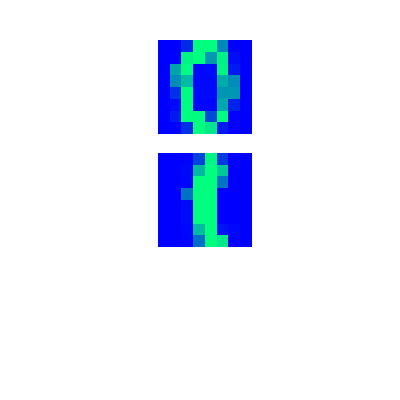

In [16]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()

Два нейрона последнего слоя конкурируют за ресурсы, проверим, что они имеют противоположные негативные веса относительно друг друга.

<IPython.core.display.Javascript object>


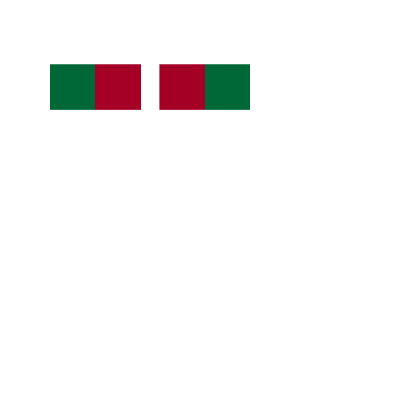

In [17]:
z = S_neg.w
for i in np.arange(int(len(G))):
    z = insert(z, i+int(len(G))*i, 0)
    
images_out_neg = np.array(z).reshape(int(len(G)), 1, 2)

k=1
figure('negative weight visualisation', figsize=(5,5))
for image in images_out_neg:
    subplot(3, 3, k)
    imshow(image, cmap='RdYlGn', interpolation='None')
    axis('off')
    
    k+=1

show()


Проверяем, меняется ли у нас вообще инпут? Как мы видим яркость пикселей действительно меняется, то что нужно!

<IPython.core.display.Javascript object>


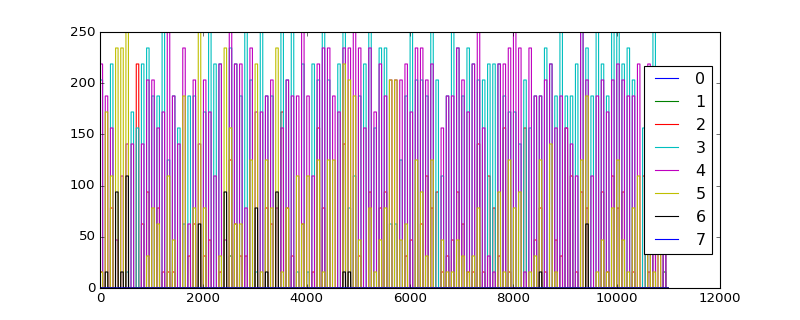

In [18]:
figure('P_rates', figsize=(10,4))
for k in np.arange(8):
    plot(StateMonitorP.t/ms, StateMonitorP.rates[k], linewidth=1, label = str(k))
legend(loc='best')
show()


Проверим так же, что нейроны входного слоя(первый график) и нейроны выходного слоя(второй график) спайкуют по разному в зависимости от входной картинки. Второй график более информативный , на нем мы можем заметить, что два нейрона спайкуют обособленно(почти), то есть они действительно отвечают за 2 разных класса и когда на вход приходит изображение нуля, спайкует один нейрон, а когда изображение единицы, то другой.

<IPython.core.display.Javascript object>


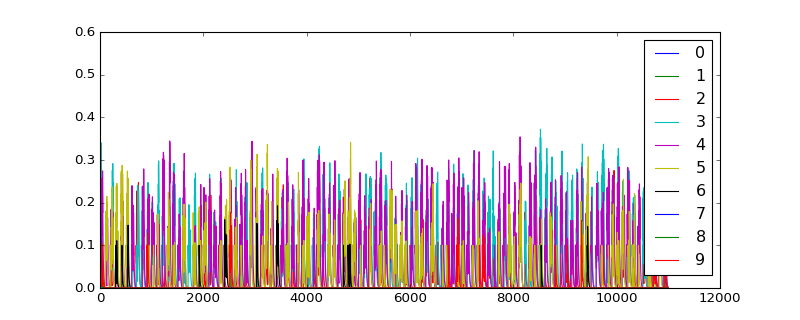

<IPython.core.display.Javascript object>


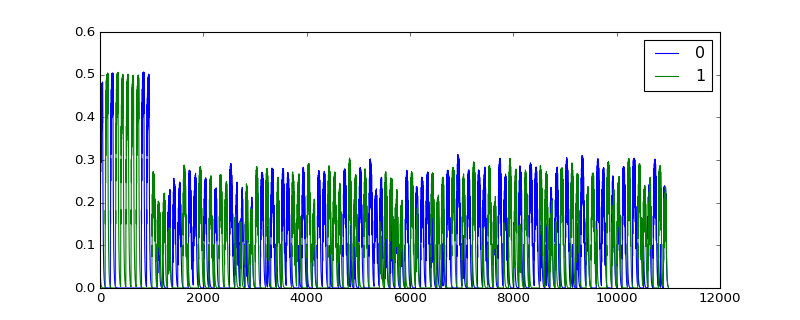

In [19]:
figure('P_a', figsize=(10,4))
for k in np.arange(10):
    plot(StateMonitorP.t/ms, StateMonitorP.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

figure('G_a', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()


На этом графике мы можем наблюдать изменение входных токов в последний слой(из 2-х нейронов) и отрицательных токов между этими двумя нейронами. Как мы видим, нейроны с помощью весов стараются увеличить входной ток от предыдущего слоя, чтобы спайковать чаще и стараются уменьшить негативный ток. Положительный ток доходит до максимума ресурсов, которые возможно собрать со входного слоя, а негативный до отметки, являющейся неким оптимумом.

<IPython.core.display.Javascript object>


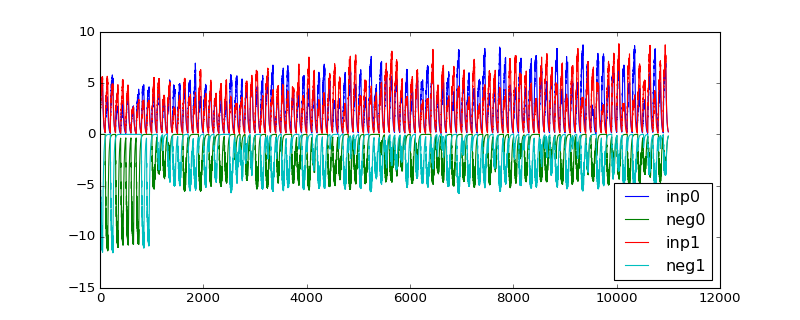

In [20]:
figure('G_I', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.I_inp[k], linewidth=1, label = 'inp' + str(k))
    plot(StateMonitorG.t/ms, StateMonitorG.I_neg[k], linewidth=1, label = 'neg' + str(k))
legend(loc='best')
show()

Посмотрим на веса входных нейронов. Часть из них растёт, часть затухает, часть находится где-то в середине. Первые отвечают за пиксели, которые есть и в нулях и в единицах, вторые за пиксели, которые пустуют и там и там, а третьи за пиксели, которые в зависимости от картинки могут быть яркими, а могут и не быть.

<IPython.core.display.Javascript object>


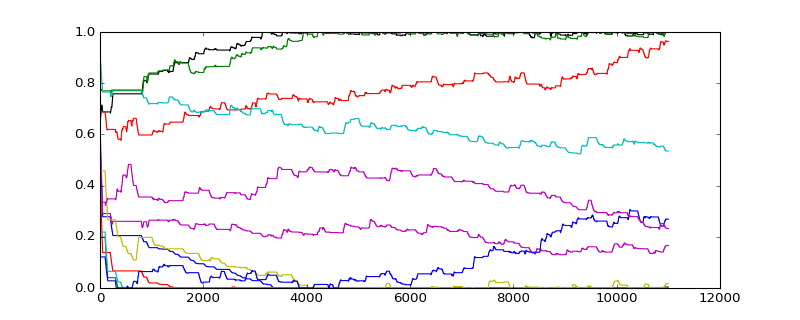

In [21]:
figure('input weights', figsize=(10,4))
for k in np.arange(12):
    plot(StateMonitorS.t/ms, StateMonitorS.w[k], linewidth=1, label = str(k))
#legend(loc='best')
show()

Тут мы снова наблюдаем, что негативные веса, отвечающие за то, что нейроны двух классов отбирают друг у друга ресурсы приходят к некому оптимуму.

<IPython.core.display.Javascript object>


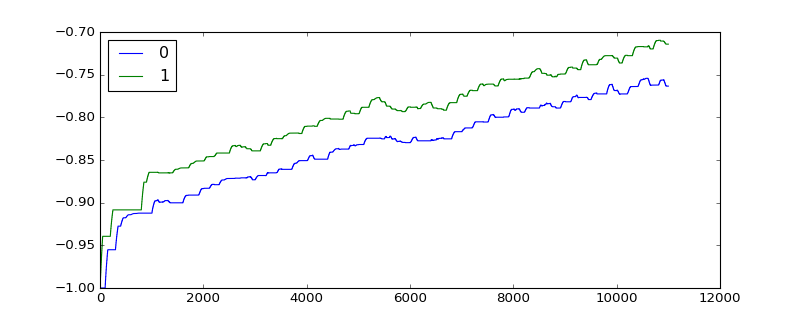

In [22]:
figure('negative intr weights', figsize=(10,4))
for k in np.arange(len(S_neg)):
    plot(StateMonitorS_neg.t/ms, StateMonitorS_neg.w[k], linewidth=1, label = str(k))
legend(loc='best')
show()


Ну и на последок посмотрим как обстоят дела с тестовой выборкой. Особенность спайковых нейронных сетей состоит в том, что они могут доучиваться даже на тестовой выборке, работая без учителя, как модель кластеризации. До этого на нейрон последнего слоя, отвечающий за данный класс, приходил ток учителя, который мы подавали в ручную, на тесте мы его отключаем.

Точность 97%, не так уж и плохо для модели из 2-х слоев по 64 и 2 нейрона.

In [15]:
#P.rates = np.zeros_like(P.rates)
#G.I_teacher = np.zeros_like(G.I_teacher)
predictions = []
labels = []
counter = 0
train = 0

run(10000*ms)

#add last prediction
#predictions.append(np.argmax(np.mean(StateMonitorG.a[:,-50:], axis=1)))

print accuracy_score(predictions, labels)

0.95


На следующем графике видно, что частота спайкования на тесте(20000:30000) уменьшилась, это как раз связано с тем, что мы отключили ток учителя.

<IPython.core.display.Javascript object>


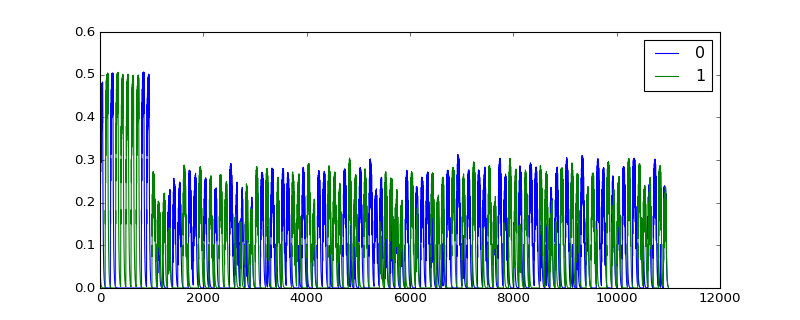

In [23]:
figure('G_a_test', figsize=(10,4))
for k in np.arange(len(G)):
    plot(StateMonitorG.t/ms, StateMonitorG.a[k], linewidth=1, label = str(k))
legend(loc='best')
show()

И наконец снова посмотрим на веса, уже после дообучения без учителя.

<IPython.core.display.Javascript object>


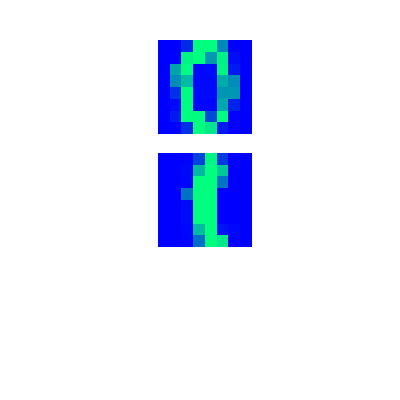

In [24]:
images_input = [[S.w[r + j * int(len(G))]
         for j in np.arange(len(P))] 
         for r in np.arange(len(G))]
images_input = np.array(images_input).reshape(int(n_hidden), int(n_input_width), int(n_input_height))


k=1
figure('input Weight visualisation test', figsize=(5,5))
for image in images_input:
    subplot(3, 1, k)
    imshow(image, cmap='winter', interpolation='None')
    axis('off')

    k+=1

show()

Спасибо за внимание!